In [2]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [3]:
#POPRAWA BOGDAN
url = "C:/Users/kmala/PycharmProjects/ASI_project_ZIMA/data/01_raw/sample.csv"

df = pd.read_csv(url, sep=';', engine='python')

df.head()

,lp,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
df.info()
df.describe()
df['satisfaction'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   lp                                 1001 non-null   int64  
 1   id                                 1001 non-null   int64  
 2   Gender                             1001 non-null   object 
 3   Customer Type                      1001 non-null   object 
 4   Age                                1001 non-null   int64  
 5   Type of Travel                     1001 non-null   object 
 6   Class                              1001 non-null   object 
 7   Flight Distance                    1001 non-null   int64  
 8   Inflight wifi service              1001 non-null   int64  
 9   Departure/Arrival time convenient  1001 non-null   int64  
 10  Ease of Online booking             1001 non-null   int64  
 11  Gate location                      1001 non-null   int64

satisfaction
neutral or dissatisfied    0.56044
satisfied                  0.43956
Name: proportion, dtype: float64

In [5]:
df['satisfaction'] = df['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
for col in cat_cols:
    df[col] = df[col].astype('category')

X = df.drop('satisfaction', axis=1)
y = df['satisfaction']


In [6]:

# print(df['satisfaction'].head(10).tolist())


# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



satisfaction
0    561
1    440
Name: count, dtype: int64


In [8]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols, reference=train_data)

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	train's binary_logloss: 0.0582192	valid's auc: 0.977273	valid's binary_logloss: 0.190116
Early stopping, best iteration is:
[134]	train's auc: 1	train's binary_logloss: 0.0317889	valid's auc: 0.979988	valid's binary_logloss: 0.187523


In [9]:
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.9402985074626866
AUC: 0.9799879324215608
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       113
           1       0.94      0.92      0.93        88

    accuracy                           0.94       201
   macro avg       0.94      0.94      0.94       201
weighted avg       0.94      0.94      0.94       201



<Figure size 1000x600 with 0 Axes>

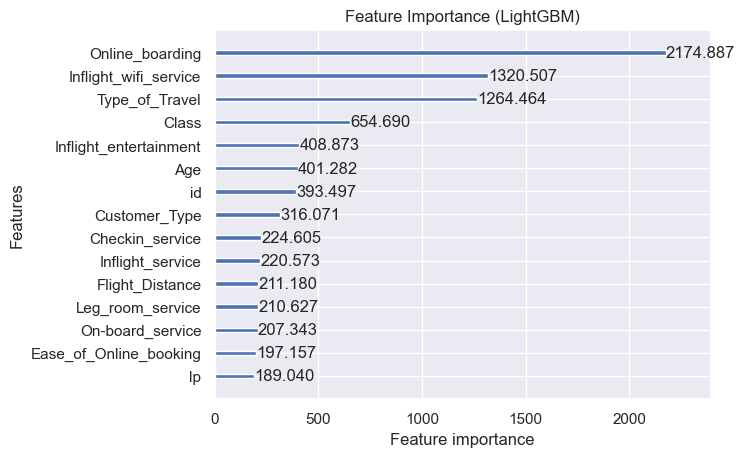

In [10]:
plt.figure(figsize=(10,6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Feature Importance (LightGBM)")
plt.show()


In [12]:
#EWENTUALNIE TUTAJ JAK CHCEMY ZAPISAĆ
model.save_model("lightgbm_baseline.txt")


LightGBMError: Model file notebooks/lightgbm_baseline.txt is not available for writes